# Estudio de Campo – Benchmark MLLM 

**Autor**: [Pedro Ismael Ruiz](https://www.linkedin.com/in/pdro-ruiz/)  
**Fecha**: 3 de marzo de 2025  

---

## Introducción

Este proyecto es un ensayo para ejemplificar y evaluar la eficacia y eficiencia de dos modelos de lenguaje multimodal (MLLM), **IDEFICS2** y **BLIP2**, en un entorno local. Aunque estos modelos puedan considerarse algo antiguos, son idóneos para ilustrar el proceso de *benchmarking* en un contexto controlado. Más allá de los modelos específicos empleados, el valor de este trabajo radica en su potencial como punto de partida para futuras expansiones. La experiencia que se adquiera permitirá la posibilidad de escalar este enfoque hacia entornos *cloud* con mayor capacidad computacional, integrando un conjunto más amplio de modelos y tareas multimodales. Donde podriamos incluir la exploración de técnicas como la inferencia distribuida o la incorporación de métricas adicionales, sentando las bases de un *benchmarking* más ambicioso y sofisticado en en futuras iteraciones.

El análisis se centra en dos tareas:  

- **Generación de subtítulos** (*captioning*)  
- **Respuesta a preguntas visuales** (*Visual Question Answering*, VQA)  

Para el conjunto de imágenes, se ha seleccionado un subconjunto de la partición de validación de **COCO 2017** (solo **10 imágenes** para agilizar la prueba). Se miden los siguientes aspectos:

1. **Tiempo de inferencia** (en segundos).  
2. **Uso de memoria VRAM** (en GB).  
3. **Calidad de las respuestas**, usando la métrica **BLEU**.  

En el futuro, se podrían incorporar más modelos y modalidades para extender este benchmark.

<p align="center">
  <img src="img/benchmark.png" alt="Benchamarl">
</p>

## Configuración Inicial

En primer lugar, se importan las bibliotecas esenciales: `os`, `torch`, `transformers` (para manejar IDEFICS2 y BLIP2), `PIL`, `time`, `pandas`, `nltk`, `matplotlib` y `seaborn`. Asimismo, se comprueba la disponibilidad de `punkt` en `nltk` para calcular el BLEU.

Se selecciona el dispositivo (`device`) en función de si existe una GPU (`"cuda"`) o no, y se define la ruta a la carpeta de imágenes (`data/coco/val2017`). Los resultados se almacenan en `results`. Para esta demostración, se procesan solamente las primeras 10 imágenes de COCO.  

Además, se han definido dos preguntas básicas de VQA para todos los modelos:

1. **"Are there people in the image?"**  
2. **"Which color predominates in the image?"**


In [6]:
# Importaciones
import os
import torch
from transformers import (
    Idefics2Processor, Idefics2ForConditionalGeneration, 
    Blip2Processor, Blip2ForConditionalGeneration
)
from PIL import Image
import time
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# Verificación y descarga del tokenizer de BLEU si es necesario
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")

# Configuración del dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")

# Configuración de rutas
image_dir = "data/coco/val2017"
output_dir = "results"
analysis_dir = os.path.join(output_dir, "analysis")

# Asegurar que los directorios existen
for directory in [output_dir, analysis_dir]:
    os.makedirs(directory, exist_ok=True)

Usando dispositivo: cuda


## Definición de modelos y función de inferencia

En este apartado configuramos los modelos **IDEFICS2 (8B)** y **BLIP2 (OPT-2.7B)**. Cuando vemos el sufijo **B** en el nombre de un modelo, nos indica la cantidad de parámetros que posee dicho modelo; por ejemplo, *8B* equivale a **8 mil millones de parámetros**, mientras que *2.7B* equivale a **2,7 mil millones de parámetros**. Estos datos suelen ayudar a estimar el poder de razonamiento y la memoria necesaria para ejecutar el modelo.

Ambos modelos se definen en un diccionario que incluye sus identificadores, clases de procesador y modelo, y los *prompts* para *captioning*. Concretamente:
- **IDEFICS2** emplea el *prompt*: `<image>Describe la imagen con detalle:`
- **BLIP2** emplea un *prompt* más sencillo: `Describe la imagen con detalle:`

Posteriormente, se implementa la función de inferencia (`infer`) encargada de realizar tanto *captioning* como VQA sobre una imagen. Realiza los pasos siguientes:

1. **Apertura de la imagen** en formato `RGB`.  
2. **Generación del subtítulo**, añadiendo etiquetas especiales como `<image>` en IDEFICS2 o un simple *prompt* en BLIP2.  
3. **Cálculo de tiempos**: se registra el inicio y fin de la inferencia para medir la latencia.  
4. **Uso de VRAM**: en caso de usar CUDA, se obtienen los valores de `torch.cuda.memory_allocated()`.  
5. **Respuesta a la pregunta VQA**: se añade un *prompt* específico, por ejemplo:
   ```
   <image>Pregunta: {question}
   ```
   en el caso de IDEFICS2, y la predicción se ejecuta de forma muy similar al subtitulado.  
6. **Retorno** de todos estos valores para cada imagen y cada modelo.

In [2]:
# Lista de imágenes
image_dir = "data/coco/val2017"  # Asegúrate de ajustar esta ruta según tu entorno
images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))][:10]
if not images:
    raise FileNotFoundError(f"Error! No se encontraron imágenes en {image_dir}.")

# Preguntas VQA
vqa_questions = [
    "Are there people in the image?",
    "Which color predominates in the image?"
]

# Definición de modelos
models = {
    "IDEFICS2": {
        "model_id": "HuggingFaceM4/idefics2-8b",
        "processor_class": Idefics2Processor,
        "model_class": Idefics2ForConditionalGeneration,
        "caption_prompt": "<image>Describe the image in detail"
    },
    "BLIP2": {
        "model_id": "Salesforce/blip2-opt-2.7b",
        "processor_class": Blip2Processor,
        "model_class": Blip2ForConditionalGeneration,
        "caption_prompt": ""  # Prompt vacío para BLIP2
    }
}

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Función para inferencia
def infer(model, processor, image_path, caption_prompt, vqa_question, model_name):
    image = Image.open(image_path).convert("RGB")
    if "BLIP2" in model_name:
        image = image.resize((224, 224))
    
    caption_text = "" if "BLIP2" in model_name else caption_prompt
    inputs = processor(images=image, text=caption_text, return_tensors="pt").to(device)
    start = time.time()
    print(f"{model_name} - Generando subtítulo con num_beams={5 if 'BLIP2' in model_name else 1}")
    output_ids = model.generate(
        **inputs,
        max_new_tokens=50,
        num_beams=5 if "BLIP2" in model_name else 1,
        no_repeat_ngram_size=2 if "BLIP2" in model_name else 0
    )
    caption = processor.decode(output_ids[0], skip_special_tokens=True)
    caption_time = time.time() - start
    vram = torch.cuda.memory_allocated() / 1024**3 if torch.cuda.is_available() else 0
    
    # Subtitulado
    caption_text = "" if "BLIP2" in model_name else caption_prompt  # Usar prompt vacío para BLIP2
    inputs = processor(images=image, text=caption_text, return_tensors="pt").to(device)
    start = time.time()
    output_ids = model.generate(
        **inputs,
        max_new_tokens=50,
        num_beams=5 if "BLIP2" in model_name else 1,  # Beam search para BLIP2
        no_repeat_ngram_size=2 if "BLIP2" in model_name else 0  # Evitar repeticiones en BLIP2
    )
    caption = processor.decode(output_ids[0], skip_special_tokens=True)
    caption_time = time.time() - start
    vram = torch.cuda.memory_allocated() / 1024**3 if torch.cuda.is_available() else 0
    
    # VQA
    vqa_text = vqa_question if "BLIP2" in model_name else f"<image>Q: {vqa_question}"
    inputs_vqa = processor(images=image, text=vqa_text, return_tensors="pt").to(device)
    start_vqa = time.time()
    vqa_ids = model.generate(
        **inputs_vqa,
        max_new_tokens=10,
        num_beams=5 if "BLIP2" in model_name else 1,  # Beam search para BLIP2
        no_repeat_ngram_size=2 if "BLIP2" in model_name else 0  # Evitar repeticiones en BLIP2
    )
    vqa_answer = processor.decode(vqa_ids[0], skip_special_tokens=True)
    vqa_time = time.time() - start_vqa
    
    return caption, caption_time, vqa_answer, vqa_time, vram

## Ejecución del Benchmark

Se recorre la lista de modelos (`models.items()`) y, para cada uno, se itera sobre todas las imágenes y preguntas VQA. Los resultados se van guardando en una lista, que finalmente se convierte en un *DataFrame* de `pandas`. Este DataFrame se exporta a un CSV llamado `benchmark_results.csv`.

Se observa en la salida impresa en pantalla que, para cada imagen, el modelo genera un subtítulo y una respuesta VQA, junto con el tiempo y el consumo de VRAM. En el caso de IDEFICS2, suele mostrar *prompts* más extensos y explicaciones más detalladas. BLIP2, por otro lado, presenta salidas más concisas.

In [3]:
# Resultados
results = []
print("Iniciando benchmark...")

for model_name, config in models.items():
    print(f"Cargando {model_name}...")
    processor = config["processor_class"].from_pretrained(config["model_id"])
    if "BLIP2" in model_name:
        # Cargar BLIP2 sin cuantización de 4 bits para evitar shape mismatch
        model = config["model_class"].from_pretrained(
            config["model_id"],
            torch_dtype=torch.float16,
            device_map={"": 0}
        )
    else:
        # Mantener configuración original para IDEFICS2
        model = config["model_class"].from_pretrained(
            config["model_id"],
            torch_dtype=torch.float16,
            load_in_4bit=True,  # Requiere bitsandbytes instalado
            device_map={"": 0}
        )
    model.eval()
    
    try:
        model.to(device)
    except RuntimeError as e:
        print(f"No se pudo mover {model_name} a GPU: {e}. Usando offloading...")
        model = config["model_class"].from_pretrained(
            config["model_id"],
            torch_dtype=torch.float16,
            load_in_4bit=True if "IDEFICS2" in model_name else False,
            llm_int8_enable_fp32_cpu_offload=True,
            device_map={"": "cuda:0", "transformer": "cpu"}
        )
        model.eval()
    
    for img_path in images:
        for question in vqa_questions:
            try:
                caption, cap_time, vqa_answer, vqa_time, vram = infer(
                    model, processor, img_path, config["caption_prompt"], question, model_name
                )
                reference = ["Una imagen con personas y objetos variados"]
                bleu_score = sentence_bleu([reference[0].split()], caption.split())
                
                results.append({
                    "Model": model_name,
                    "Image": os.path.basename(img_path),
                    "Caption": caption,
                    "Caption Time (s)": cap_time,
                    "VQA Question": question,
                    "VQA Answer": vqa_answer,
                    "VQA Time (s)": vqa_time,
                    "VRAM (GB)": vram,
                    "BLEU Score": bleu_score
                })
                print(f"{model_name} - {os.path.basename(img_path)} - Caption: {caption[:50]}... - VQA: {vqa_answer}")
            except Exception as e:
                print(f"Error en {model_name} con {img_path}: {str(e)}")
    
    del model, processor
    torch.cuda.empty_cache()
    print(f"{model_name} completado.\n")

# Guardar resultados
output_dir = "results"  # Asegúrate de ajustar esta ruta según tu entorno
df = pd.DataFrame(results)
output_file = os.path.join(output_dir, "benchmark_results.csv")
df.to_csv(output_file, index=False)
print(f"Resultados guardados en {output_file}")

Iniciando benchmark...
Cargando IDEFICS2...


Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 7/7 [00:22<00:00,  3.19s/it]
You shouldn't move a model that is dispatched using accelerate hooks.


IDEFICS2 - Generando subtítulo con num_beams=1


c:\Users\pedro\miniconda\envs\Sparkml\lib\site-packages\bitsandbytes\nn\modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


IDEFICS2 - 000000000139.jpg - Caption: Describe the image in detail.
TDM

In this image I... - VQA: Q: Are there people in the image?
TDM: Yes.

Q: What
IDEFICS2 - Generando subtítulo con num_beams=1
IDEFICS2 - 000000000139.jpg - Caption: Describe the image in detail.
TDM

In this image I... - VQA: Q: Which color predominates in the image?
TDM: Yellow.
IDEFICS2 - Generando subtítulo con num_beams=1
IDEFICS2 - 000000000285.jpg - Caption: Describe the image in detail.
TDM... - VQA: Q: Are there people in the image?
TDM: No.
IDEFICS2 - Generando subtítulo con num_beams=1
IDEFICS2 - 000000000285.jpg - Caption: Describe the image in detail.
TDM... - VQA: Q: Which color predominates in the image?
TDM: Green.
IDEFICS2 - Generando subtítulo con num_beams=1
IDEFICS2 - 000000000632.jpg - Caption: Describe the image in detail.
TDM

The bedroom has... - VQA: Q: Are there people in the image?
TDM: No.
IDEFICS2 - Generando subtítulo con num_beams=1
IDEFICS2 - 000000000632.jpg - Caption: Describe the

Loading checkpoint shards: 100%|██████████| 2/2 [00:12<00:00,  6.24s/it]


BLIP2 - Generando subtítulo con num_beams=5
BLIP2 - 000000000139.jpg - Caption: a living room filled with furniture and a fireplac... - VQA:  Yes, there are people in the image

BLIP2 - Generando subtítulo con num_beams=5
BLIP2 - 000000000139.jpg - Caption: a living room filled with furniture and a fireplac... - VQA: 

BLIP2 - Generando subtítulo con num_beams=5
BLIP2 - 000000000285.jpg - Caption: a large brown bear sitting in the grass
... - VQA: 

BLIP2 - Generando subtítulo con num_beams=5
BLIP2 - 000000000285.jpg - Caption: a large brown bear sitting in the grass
... - VQA: 

BLIP2 - Generando subtítulo con num_beams=5
BLIP2 - 000000000632.jpg - Caption: a bedroom with a blue comforter and a bookshelf
... - VQA:  Yes, there are people in the image

BLIP2 - Generando subtítulo con num_beams=5
BLIP2 - 000000000632.jpg - Caption: a bedroom with a blue comforter and a bookshelf
... - VQA: 

BLIP2 - Generando subtítulo con num_beams=5
BLIP2 - 000000000724.jpg - Caption: a stop sign on t

## Visualización de Ejemplos

Para comprobar la muestra, Implementamos un fragmento de código que:

1. Abre la imagen y la muestra con `matplotlib`.  
2. Recupera del CSV los resultados de ambos modelos para esa imagen.  
3. Imprime en el título de la figura los subtítulos generados y las respuestas a las dos preguntas de VQA.

Esto permite comparar, de un vistazo, cómo IDEFICS2 y BLIP2 describen la misma imagen y responden cuestiones como “Are there people in the image?” y “Which color predominates in the image?”.

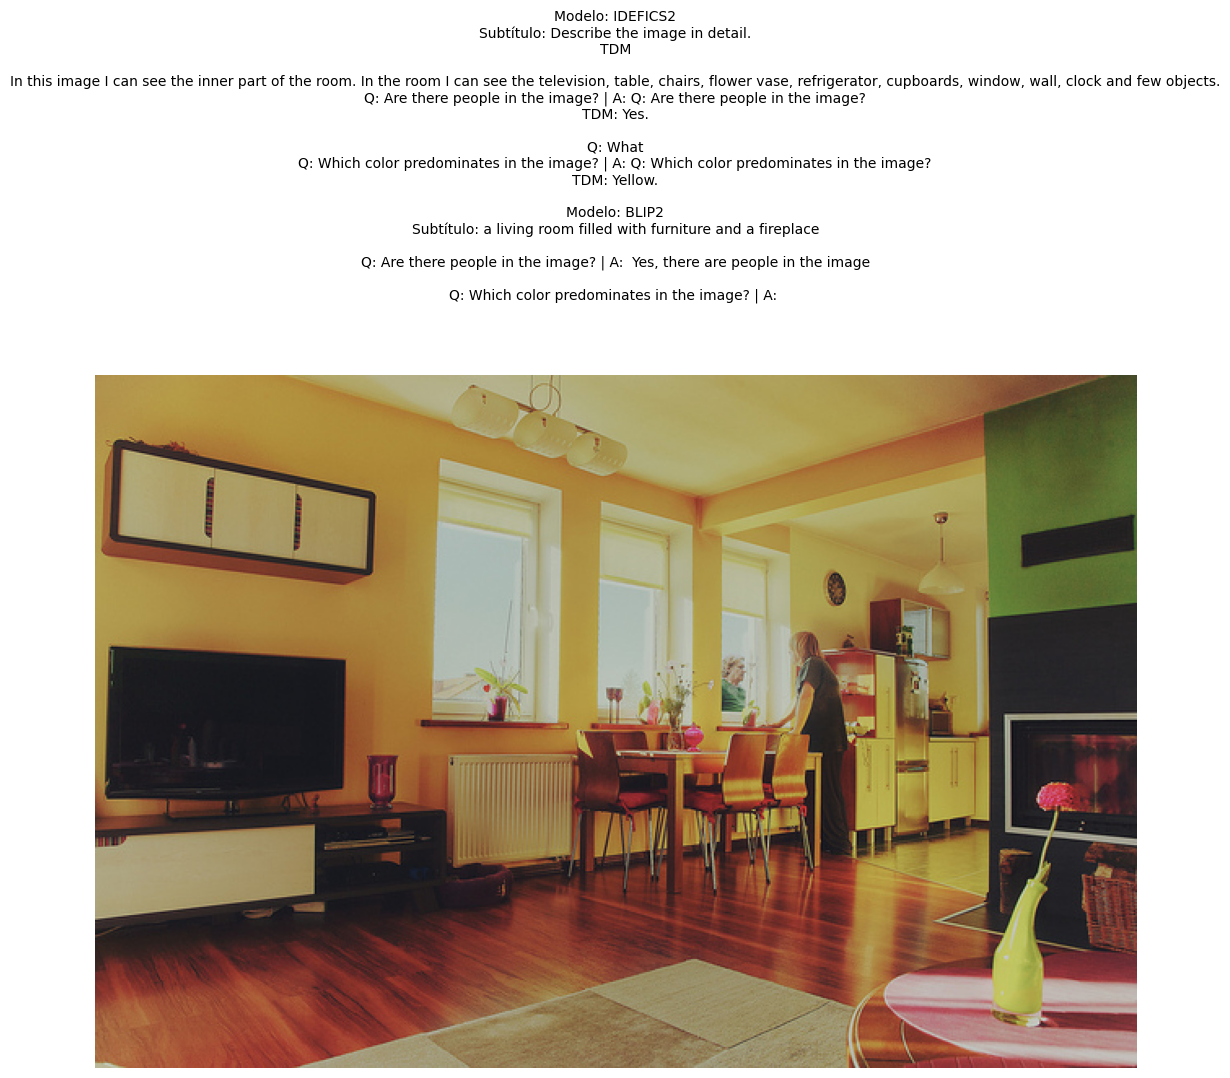

In [4]:
image_dir = "data/coco/val2017"
df = pd.read_csv("results/benchmark_results.csv")

# Agrupamos por imagen para obtener los datos de ambos modelos y preguntas
unique_images = df["Image"].unique()[:1] 

for img_name in unique_images:
    # Filtramos las filas correspondientes a esta imagen
    img_data = df[df["Image"] == img_name]
    
    # Abrimos la imagen
    image_path = os.path.join(image_dir, img_name)
    image = Image.open(image_path).convert("RGB")
    
    # Creamos una figura para la imagen
    plt.figure(figsize=(19, 9))
    plt.imshow(image)
    plt.axis("off")
    
    # Construimos el título con los resultados de ambos modelos
    title_text = ""
    
    # Procesamos cada modelo (IDEFICS2 y BLIP2)
    for model_name in ["IDEFICS2", "BLIP2"]:
        model_data = img_data[img_data["Model"] == model_name]
        if not model_data.empty:
            caption = model_data["Caption"].iloc[0]  # Tomamos el subtítulo (asumimos único por modelo e imagen)
            title_text += f"Modelo: {model_name}\n"
            title_text += f"Subtítulo: {caption}\n"
            
            # Extraemos las dos preguntas y respuestas
            for _, row in model_data.iterrows():
                title_text += f"Q: {row['VQA Question']} | A: {row['VQA Answer']}\n"
            title_text += "\n"  # Espacio entre modelos
    
    # Añadimos el título completo
    plt.title(title_text, fontsize=10, pad=20, loc="center")
    
    plt.show()

## Análisis de Resultados

Por último, se lee el CSV resultante y se agrupan los datos por modelo (`df.groupby("Model")`) para extraer estadísticas descriptivas (medias, desviaciones, valores mínimo y máximo) de los tiempos de subtitulado y VQA, así como del uso de VRAM y la puntuación BLEU.  

In [5]:
# Configurar directorio para análisis
analysis_dir = os.path.join(output_dir, "analysis")
os.makedirs(analysis_dir, exist_ok=True)

# Cargar datos
df = pd.read_csv(output_file)

# Resumen estadístico
summary = df.groupby("Model").agg({
    "Caption Time (s)": ["mean", "std", "min", "max"],
    "VQA Time (s)": ["mean", "std", "min", "max"],
    "VRAM (GB)": ["mean", "std"],
    "BLEU Score": ["mean", "std"]
}).round(3)

display(summary)
summary.to_csv(os.path.join(analysis_dir, "summary_stats.csv"))

Caption Time (s)                       VQA Time (s)                 \
                     mean    std    min     max         mean     std    min   
Model                                                                         
BLIP2               0.990  0.202  0.824   1.804        0.895   0.104  0.852   
IDEFICS2            6.286  8.233  1.883  32.733        6.307  10.312  1.579   

                 VRAM (GB)        BLEU Score       
             max      mean    std       mean  std  
Model                                              
BLIP2      1.332     7.021  0.000        0.0  0.0  
IDEFICS2  38.040     4.828  0.005        0.0  0.0

El resultado revela, a modo de ejemplo:

- **IDEFICS2**:  
  - Tiempo medio de *captioning*: ~6.3 s (desviación estándar: 8.2 s, mínimo: 1.9 s, máximo: 32.7 s)  
  - Tiempo medio de VQA: ~6.3 s (desviación estándar: 10.3 s, mínimo: 1.6 s, máximo: 38.0 s)  
  - Uso de VRAM: ~4.8 GB (desviación estándar: 0.005 GB)  
  - BLEU: ~0.0 (con la referencia genérica utilizada)  

- **BLIP2**:  
  - Tiempo medio de *captioning*: ~1.0 s (desviación estándar: 0.2 s, mínimo: 0.8 s, máximo: 1.8 s)  
  - Tiempo medio de VQA: ~0.9 s (desviación estándar: 0.1 s, mínimo: 0.9 s, máximo: 1.3 s)  
  - Uso de VRAM: ~7.0 GB (versión en `float16` sin cuantización de 4 bits, desviación estándar: 0.0 GB)  
  - BLEU: ~0.0 (debido a la referencia genérica empleada)  

> **Nota**: Las puntuaciones BLEU cercanas a 0.0 reflejan el uso de una referencia excesivamente simple ("Una imagen con personas y objetos variados"), que no captura la diversidad real de los subtítulos generados. Este valor actúa como un *placeholder* para ilustrar la métrica en este ensayo, más que como un indicador definitivo de la calidad de las descripciones.

Este pequeño estudio de campo nos has permitido comparar IDEFICS2 y BLIP2 en un entorno local. Al centrarnos tanto en la parte de código (con la gestión de 4 bits y *offloading* de GPU a CPU) como en la calidad de las salidas (subtítulos y respuestas VQA), obtenemos una visión muy concreta de las fortalezas y limitaciones de cada modelo:

- **IDEFICS2** (8B) exige menos VRAM al estar cuantizado, pero presenta latencias mayores.  
- **BLIP2** (OPT-2.7B) es más rápido en la mayoría de las inferencias, aunque su uso de VRAM es ligeramente mayor al no aplicar la cuantización de 4 bits.

---

Lo importante de este trabajo no son los modelos utilizados, sino su posible escalado en futuras iteraciones, llevandolo a entornos Cloud con mayor poder de computo y añadiendo más modelos y tareas multimodales a este pipeline, explorando las posibilidades de la inferencia distribuida o la evaluación de otras métricas.

La experimentación con esta combinación de recursos y configuraciones sienta una base sólida para escalados posteriores del *benchmark* en entornos más complejos.  